# Lösungen 8

In [68]:
from math import *
import numpy as np
from matplotlib import pyplot as plt

## Aufgabe 1
### a) Polynominterpolation
Aus notebook07.ipynb übernommen:

In [69]:
def horner(x, xs, c):
    """Berechnet den Wert des Interpolationspolynoms P_n an der Stelle x 
    für die Stützstellen xs und die Koeffizienten der Newton-Darstellung c."""
    n = len(c) - 1
    if len(xs) < n:
        raise Exception("Zu wenige Stützstellen!")
    p = c[n]
    for k in range(n-1, -1, -1):
        p = c[k] + (x - xs[k])*p
    return p 

In [70]:
def newton_coeffs(xs, ys):
    """Berechnet die Koeffizienten c des Interpolationspolynoms in 
    Newton-Darstellung für die Stützstellen xs und Werte ys."""
    n = len(xs) - 1
    if not len(ys) == n+1:
        raise Exception("""Brauche genauso viele Stützstellen wie Werte!""")
    c = 1.*ys
    for k in range(1, n+1):
        for i in range(n, k-1, -1):
            c[i] = (c[i] - c[i-1])/(xs[i] - xs[i-k])
    return c

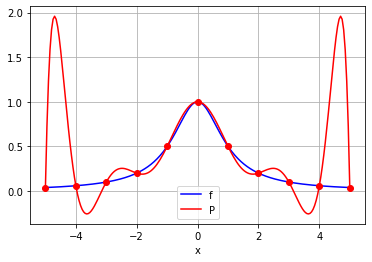

In [71]:
def f(x):
    return 1./(1. + x**2)
xs = np.linspace(-5., 5., 11)
ys = f(xs)
c = newton_coeffs(xs, ys)
x = np.linspace(-5., 5., 200)
y = horner(x, xs, c)
plt.plot(x, f(x), 'b', label='f')
plt.plot(x, y, 'r', label='P')
plt.plot(xs, ys, 'ro')
plt.grid()
plt.xlabel('x')
plt.legend()
plt.show()

In [72]:
x0 = 4.5
print("Fehler an der Stelle x = 4.5: {}".format(horner(x0, xs, c)))

Fehler an der Stelle x = 4.5: 1.5787209903492139


Vergleich mit der Fehlerabschätzung aus Satz 5.8:

In [73]:
omega = 1.
for xk in xs:
    omega *= (x0 - xk)
print("omega an der Stelle x = 4.5: {}".format(omega))

omega an der Stelle x = 4.5: -319691.93115234375


In [102]:
def f11(x):  #mit Computeralgebra berechnet
    return (1.596672e+8*x*(-3.0*x**10+55.0*x**8-198.0*x**6+198.0*x**4-55.0*x**2+3.0))/(x**24+12.0*x**22+66.0*x**20+220.0*x**18+495.0*x**16+792.0*x**14+924.0*x**12+792.0*x**10+495.0*x**8+220.0*x**6+66.0*x**4+12.0*x**2+1.0)
xfine = np.linspace(-5, 5, 1000)
f11absmax = np.max(abs(f11(xfine)))  
print("Maximum des Betrags der 11-ten Ableitung von f auf [-5, 5]: {}".format(f11absmax))

Maximum des Betrags der 11-ten Ableitung von f auf [-5, 5]: 36256380.05099993


In [99]:
print("Geschätzter Fehler an der Stelle x = 4.5: {}".format(abs(omega)*f11absmax/factorial(11)))

Geschätzter Fehler an der Stelle x = 4.5: 290375.7855113005


### b) Kubischer Spline
Aus Kapitel 3 übernommen:

In [76]:
def thomas(a, b, c, d):
    """Löst das tridiagonale lineare Gleichungssystem mit Hauptdiagonale a, rechter Nebendiagonale b, linker Nebendiagonale c und rechter Seite d. Eingabeargumente alles Zeilenvektoren."""
    n = len(d) - 1  #Indizes 0,1,...,n
    l = np.zeros(n)     #Nebendiagonale von L
    m = np.zeros(n+1)   #Hauptdiagonale von U
    y = np.zeros(n+1)   #Zwischenlösung
    x = np.zeros(n+1)   #Lösung
    #LU-Zerlegung
    m[0] = a[0]
    for i in range(n):
        l[i] = c[i+1]/m[i]
        m[i+1] = a[i+1] - l[i]*b[i]
    #Vorwärtssubstitution Ly = d
    y[0] = d[0]
    for i in range(1,n+1):
        y[i] = d[i] - l[i-1]*y[i-1]
    #Rückwärtssubstitution Ux = y
    x[n] = y[n]/m[n]
    for i in range(n-1,-1,-1):
        x[i] = (y[i] - b[i]*x[i+1])/m[i]
    return x

Aus notebook08.ipynb übernommen:

In [77]:
def cubic_spline_coeffs(xs, ys):
    """Berechnet aus den Stützstellen xs und Stützstellen ys die Koeffizienten a, b, c des kubischen Splines mit natürlichen Randbedingungen."""
    n = len(xs) - 1
    if not len(ys) == n+1:
        raise Exception("xs und ys müssen gleiche Länge haben")
    h = xs[1:n+1] - xs[0:n]
    #Koeffizienten des tridiagonalen LGS
    alpha = np.zeros(n+1)
    beta = np.zeros(n+1)
    gamma = np.zeros(n+1)
    delta = np.zeros(n+1)
    gamma[1:n] = h[0:n-1]/6.
    alpha[1:n] = (h[0:n-1] + h[1:n])/3.
    beta[1:n] = h[1:n]/6.
    delta[1:n] = (ys[2:n+1] - ys[1:n])/h[1:n] - (ys[1:n] - ys[0:n-1])/h[0:n-1]
    #natürliche Randbedingungen
    alpha[0] = 1
    alpha[n] = 1
    #Löse tridiagonales LGS mit Thomas-Algorithmus
    c = thomas(alpha, beta, gamma, delta)
    #Setze übrige Koeffizienten
    a = ys[0:n] - h[0:n]**2*c[0:n]/6. 
    b = (ys[1:n+1] - ys[0:n])/h[0:n] - h[0:n]*(c[1:n+1] - c[0:n])/6. 
    return a, b, c  

In [78]:
def evaluate_cubic_spline(x, xs, a, b, c):
    """Wertet den kubischen Spline mit den Stützstellen xs und Koeffizienten a, b, c auf x aus."""
    n = len(xs) - 1
    if not (len(a)==n and len(b)==n and len(c)==n+1):
        raise Exception("Koeffizientenvektoren haben nicht die passende Länge")
    h = xs[1:n+1] - xs[0:n]
    s = np.zeros_like(x)
    for i in range(n):
        #konstruiere logischen Vektor Ii für das Teilintervall [xs[i], xs[i+1]]
        if i==n-1:            
            Ii = np.logical_and(x >= xs[i], x <= xs[i+1])
        else:
            Ii = np.logical_and(x >= xs[i], x < xs[i+1])
        x_ = x[Ii]  #der Teil von x im Intervall [xs[i], xs[i+1]]
        #Spline-Ansatz
        si = a[i] + b[i]*(x_ - xs[i]) + (c[i]*(xs[i+1] - x_)**3 + c[i+1]*(x_ - xs[i])**3)/(6*h[i])
        s[Ii] = si
    return s

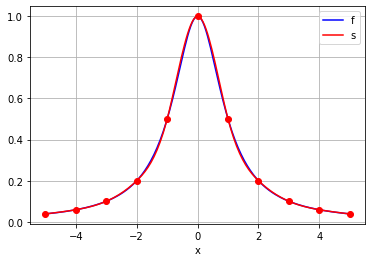

In [79]:
a, b, c = cubic_spline_coeffs(xs, ys)
s = evaluate_cubic_spline(x, xs, a, b, c)
plt.plot(x, f(x), 'b', label='f')
plt.plot(x, s, 'r', label='s')
plt.plot(xs, ys, 'ro')
plt.grid()
plt.xlabel('x')
plt.legend()
plt.show()

In [31]:
x0 = np.array([4.5])
print("Fehler an der Stelle x = 4.5: {:.2e}".format(abs(evaluate_cubic_spline(x0, xs, a, b, c)[0] - f(4.5))))

Fehler an der Stelle x = 4.5: 5.59e-04
